In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform=None, lowres_transform=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform

        # Sort to guarantee consistent order
        self.file_names = sorted([
            filename for filename in os.listdir(high_res_folder) 
            if filename.endswith('.png') and os.path.exists(os.path.join(low_res_folder, filename))
        ])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        filename = self.file_names[idx]
        high_res_path = os.path.join(self.high_res_folder, filename)
        low_res_path = os.path.join(self.low_res_folder, filename)

        high_res_image = Image.open(high_res_path).convert("RGB").resize((480,320))
        low_res_image = Image.open(low_res_path).convert("RGB").resize((120,80))

        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)
        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return high_res_image, low_res_image



#sizes
high_res_folder = "/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/train/HR"
low_res_folder = "/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/train/LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor()])
low_res_transform = transforms.Compose([
                                        transforms.ToTensor()])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)

Number of samples:  80
Sample 0:  torch.Size([3, 320, 480]) torch.Size([3, 80, 120])


In [3]:
import torch.nn as nn
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch


def _make_pair(value):
    if isinstance(value, int):
        value = (value,) * 2
    return value


def conv_layer(in_channels,
               out_channels,
               kernel_size,
               bias=False):
    kernel_size = _make_pair(kernel_size)
    padding = (int((kernel_size[0] - 1) / 2), 
               int((kernel_size[1] - 1) / 2))
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size,
                     padding=padding,
                     bias=bias)


def activation(act_type, inplace=True, neg_slope=0.05, n_prelu=1):
    
    act_type = act_type.lower()
    if act_type == 'relu':
        layer = nn.ReLU(inplace)
    elif act_type == 'lrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act_type == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    else:
        raise NotImplementedError(
            'activation layer [{:s}] is not found'.format(act_type))
    return layer


def sequential(*args):

    if len(args) == 1:
        if isinstance(args[0], OrderedDict):
            raise NotImplementedError(
                'sequential does not support OrderedDict input.')
        return args[0]
    modules = []
    for module in args:
        if isinstance(module, nn.Sequential):
            for submodule in module.children():
                modules.append(submodule)
        elif isinstance(module, nn.Module):
            modules.append(module)
    return nn.Sequential(*modules)


def pixelshuffle_block(in_channels,
                       out_channels,
                       upscale_factor=2,
                       kernel_size=3):
    conv = conv_layer(in_channels,
                      out_channels * (upscale_factor ** 2),
                      kernel_size)
    pixel_shuffle = nn.PixelShuffle(upscale_factor)
    return sequential(conv, pixel_shuffle)


class ESA(nn.Module):

    def __init__(self, esa_channels, n_feats, conv):
        super(ESA, self).__init__()
        f = esa_channels
        self.conv1 = conv(n_feats, f, kernel_size=1)
        self.conv_f = conv(f, f, kernel_size=1)
        self.conv2 = conv(f, f, kernel_size=3, stride=2, padding=0)
        self.conv3 = conv(f, f, kernel_size=3, padding=1)
        self.conv4 = conv(f, n_feats, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        c1_ = (self.conv1(x))
        c1 = self.conv2(c1_)
        v_max = F.max_pool2d(c1, kernel_size=7, stride=3)
        c3 = self.conv3(v_max)
        c3 = F.interpolate(c3, (x.size(2), x.size(3)),
                           mode='bilinear', align_corners=False)
        cf = self.conv_f(c1_)
        c4 = self.conv4(c3 + cf)
        m = self.sigmoid(c4)
        return x * m


class RRFB(nn.Module):
    def __init__(self,
                 in_channels,
                 mid_channels=None,
                 out_channels=None,
                 esa_channels=16):
        super(RRFB, self).__init__()

        if mid_channels is None:
            mid_channels = in_channels
        if out_channels is None:
            out_channels = in_channels

        self.c1_r = conv_layer(in_channels, mid_channels, 3)
        self.c2_r = conv_layer(mid_channels, mid_channels, 3)
        self.c3_r = conv_layer(mid_channels, in_channels, 3)

        self.c5 = conv_layer(in_channels, out_channels, 1)
        self.esa = ESA(esa_channels, out_channels, nn.Conv2d)

        self.act = activation('lrelu', neg_slope=0.05)

    def forward(self, x):
        out_33 = (self.c1_r(x))
        out = self.act(out_33)

        out_33 = (self.c2_r(out))
        out = self.act(out_33)

        out_33 = (self.c3_r(out))
        out = self.act(out_33)

        out = out + x
        out = self.esa(self.c5(out))

        return out


def make_model(args, parent=False):
    model = DIPNet()
    return model


class DIPNet(nn.Module):

    def __init__(self,
                 in_channels=3,
                 out_channels=3,
                 feature_channels=44,
                 upscale=4):
        super(DIPNet, self).__init__()

        self.conv_1 = conv_layer(in_channels,
                                       feature_channels,
                                       kernel_size=3)

        self.block_1 = RRFB(feature_channels, mid_channels=38)
        self.block_2 = RRFB(feature_channels, mid_channels=38)
        self.block_3 = RRFB(feature_channels, mid_channels=38)
        self.block_4 = RRFB(feature_channels, mid_channels=38)

        self.conv_2 = conv_layer(feature_channels,
                                   feature_channels,
                                   kernel_size=3)

        self.upsampler = pixelshuffle_block(feature_channels,
                                          out_channels,
                                          upscale_factor=upscale)

    def forward(self, x):
        out_feature = self.conv_1(x)

        out_b1 = self.block_1(out_feature)
        out_b2 = self.block_2(out_b1)
        out_b3 = self.block_3(out_b2)
        out_b4 = self.block_4(out_b3)


        out_low_resolution = self.conv_2(out_b4) + out_feature
        output = self.upsampler(out_low_resolution)

        return output

In [4]:
#Training DIPNet
import torch
import torch.nn as nn
from alive_progress import alive_bar
import numpy as np
from torch.utils.data import Dataset, DataLoader
class DIPNetTrainer:
    def __init__(self, model, train_loader, val_loader, lr=1e-4, epochs=10, device="cuda"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        self.epochs = epochs
        self.device = device

        self.model.to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0
            best_val_loss = 1

            with alive_bar(len(self.train_loader) , force_tty = True) as bar:
                for i, data in enumerate(self.train_loader):
                    high_res, low_res = data
                    high_res, low_res = high_res.to(self.device , dtype=torch.float), low_res.to(self.device , dtype=torch.float)

                    self.optimizer.zero_grad()
                    outputs = self.model(low_res)
                    loss = self.criterion(outputs, high_res)
                    loss.backward()
                    self.optimizer.step()

                    train_loss += loss.item()
                    bar()

            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {train_loss/len(self.train_loader)}")
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                with alive_bar(len(self.val_loader) , force_tty = True) as bar:
                    for i, data in enumerate(self.val_loader):
                        high_res, low_res = data
                        high_res, low_res = high_res.to(self.device , dtype=torch.float), low_res.to(self.device , dtype=torch.float)

                        outputs = self.model(low_res)
                        loss = self.criterion(outputs, high_res)

                        val_loss += loss.item()
                        bar()

                print(f"Validation Loss: {val_loss/len(self.val_loader)}")
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.save_model("best_model_Superres.pth")     

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))

    def predict(self, low_res):
        self.model.eval()
        with torch.no_grad():
            low_res = low_res.to(self.device)
            output = self.model(low_res)
        return output
    
#Training
high_res_folder = "/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/train/HR"
low_res_folder = "/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/train/LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor()])

low_res_transform = transforms.Compose([
                                        transforms.ToTensor()])
dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

model = DIPNet(in_channels=3, out_channels=3, feature_channels=80, upscale=4)

trainer = DIPNetTrainer(model, train_loader, val_loader, lr=1e-4, epochs=500, device="cuda")


#sample model input
low_res = torch.rand(1,3,120,80)
output = trainer.predict(low_res)
print("Output Size: ", output.shape)

Output Size:  torch.Size([1, 3, 480, 320])


In [67]:
#training
trainer.train()

|████████████████████████████████████████| 72/72 [100%] in 1.0s (72.16/s)       
Epoch 1/500, Loss: 0.07493218652800554
|████████████████████████████████████████| 8/8 [100%] in 0.1s (78.86/s)         
Validation Loss: 0.014739258331246674
|████████████████████████████████████████| 72/72 [100%] in 1.1s (68.81/s)       
Epoch 2/500, Loss: 0.01402628880330465
|████████████████████████████████████████| 8/8 [100%] in 0.2s (64.32/s)         
Validation Loss: 0.01267033105250448
|████████████████████████████████████████| 72/72 [100%] in 1.1s (65.32/s)       
Epoch 3/500, Loss: 0.01188721429854114
|████████████████████████████████████████| 8/8 [100%] in 0.1s (78.81/s)         
Validation Loss: 0.010988623893354088
|████████████████████████████████████████| 72/72 [100%] in 1.0s (71.04/s)       
Epoch 4/500, Loss: 0.010184383960828805
|████████████████████████████████████████| 8/8 [100%] in 0.1s (78.97/s)         
Validation Loss: 0.009643096069339663
|████████████████████████████████████████| 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.030873492..1.1104374].


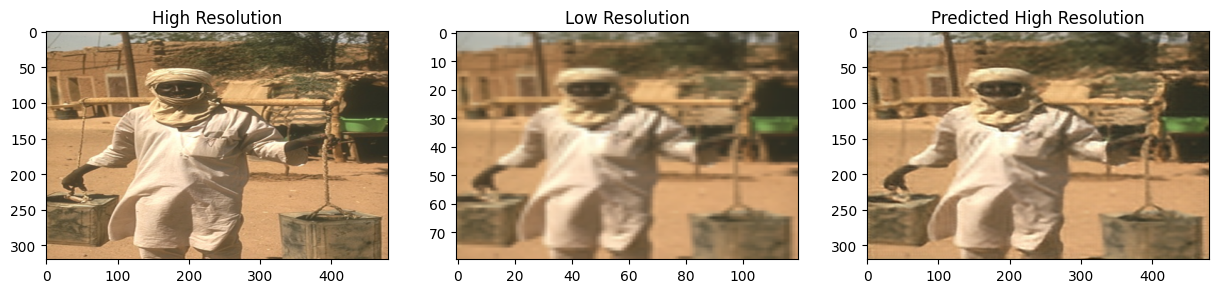

In [5]:
high_res_folder = "/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/test/HR"
low_res_folder = "/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/test/LR"   
test_dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06637984..1.1775305].


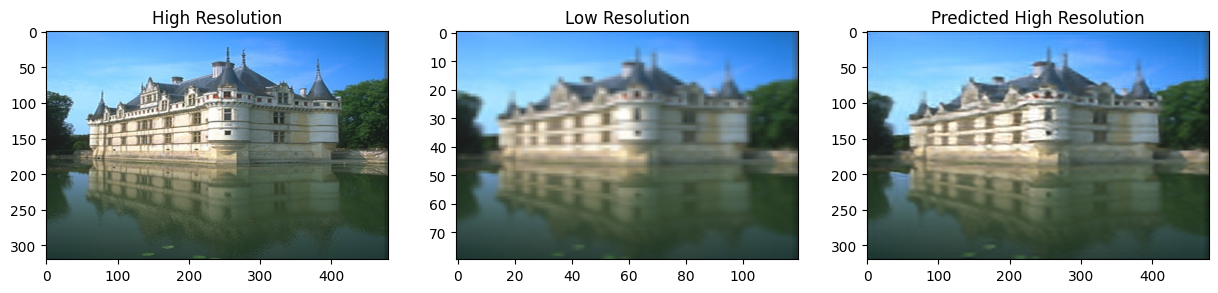

In [11]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load("/ssd_scratch/harish.j/SISR/weights/Dipnet_sr.pth"))

high_res, low_res = test_dataset[0]
low_res = low_res.unsqueeze(0)
low_res = low_res.to(torch.float)
output = trainer.predict(low_res)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(high_res.permute(1,2, 0))
ax[0].set_title("High Resolution")
ax[1].imshow(low_res.squeeze(0).permute(1,2, 0))
ax[1].set_title("Low Resolution")
# print("Low Res Shape: ", low_res.squeeze(0).shape)
# print("Output Shape: ", output.shape)
ax[2].imshow(output.cpu().squeeze(0).permute(1,2, 0))
ax[2].set_title("Predicted High Resolution")
plt.show()

In [54]:
!pip install piq

In [71]:
# MSE (Mean Squared Error), SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio)
import numpy as np
import torch
import piq
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def psnr(y_true, y_pred):
    return peak_signal_noise_ratio(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

def ssim_score(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

metrics = {'MSE': [], 'PSNR': [], 'SSIM': []}

model.load_state_dict(torch.load("best_model_Superres.pth"))

with alive_bar(len(test_dataset) , force_tty = True) as bar:
    for i in range(len(test_dataset)):
        high_res, low_res = test_dataset[i]
        low_res = low_res.unsqueeze(0)
        low_res = low_res.to(torch.float)
        output = trainer.predict(low_res)

        high_res = high_res.numpy()
        output = output.cpu().squeeze(0).numpy()
        low_res = low_res.squeeze(0).numpy()
        # print("High Res Shape: ", high_res.shape)
        # print("Output Shape: ", output.shape)
        # print("Low Res Shape: ", low_res.shape)
        metrics['MSE'].append(mse(high_res, output))
        metrics['PSNR'].append(psnr(high_res, output))
        high_res = high_res.reshape((1,3,320,480))
        output = output.reshape((1,3,320,480))
        # print("High Res Shape: ", high_res.shape)
        # print("Output Shape: ", output.shape)
        high_res = torch.tensor(high_res, dtype=torch.float32)
        output = torch.tensor(output, dtype=torch.float32)
        # Clip values to [0, 1] for SSIM calculation
        high_res = torch.clamp(high_res, 0.0, 1.0)
        output = torch.clamp(output, 0.0, 1.0)
        metrics['SSIM'].append(piq.ssim(output, high_res))
        bar()

average_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
average_metrics

|                                        | ▁▃▅ 0/20 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 20/20 [100%] in 0.5s (42.92/s)       


{'MSE': np.float32(0.0026009514),
 'PSNR': np.float64(27.611260453450804),
 'SSIM': np.float32(0.6928239)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09257949..1.1556029].


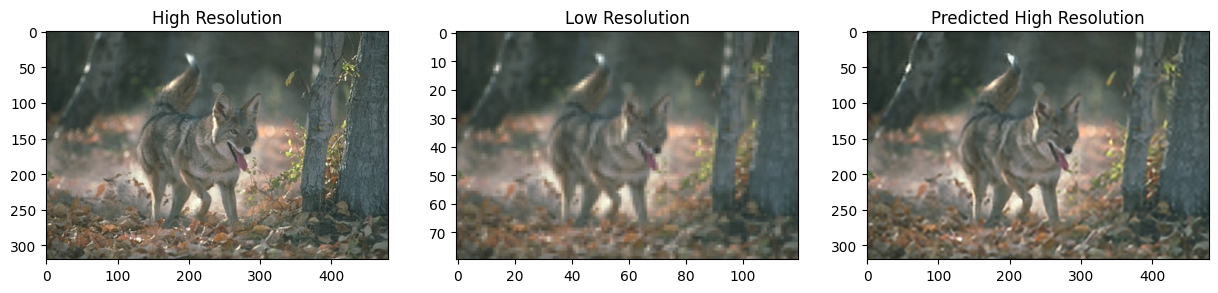

In [13]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load("/ssd_scratch/harish.j/SISR/weights/Dipnet_sr.pth"))

high_res, low_res = test_dataset[1]
low_res = low_res.unsqueeze(0)
low_res = low_res.to(torch.float)
output = trainer.predict(low_res)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(high_res.permute(1,2, 0))
ax[0].set_title("High Resolution")
ax[1].imshow(low_res.squeeze(0).permute(1,2, 0))
ax[1].set_title("Low Resolution")
# print("Low Res Shape: ", low_res.squeeze(0).shape)
# print("Output Shape: ", output.shape)
ax[2].imshow(output.cpu().squeeze(0).permute(1,2, 0))
ax[2].set_title("Predicted High Resolution")
plt.show()